# **Imports and Setup**

In [64]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
!cp drive/MyDrive/Premier_League_Predictor/train_2018-24/FWD/inputs.csv .
!cp drive/MyDrive/Premier_League_Predictor/train_2018-24/FWD/labels.csv .
!cp drive/MyDrive/Premier_League_Predictor/train_2018-24/DEF/inputs.csv .
!cp drive/MyDrive/Premier_League_Predictor/train_2018-24/DEF/labels.csv .
!cp drive/MyDrive/Premier_League_Predictor/train_2018-24/MID/inputs.csv .
!cp drive/MyDrive/Premier_League_Predictor/train_2018-24/MID/labels.csv .
!cp drive/MyDrive/Premier_League_Predictor/train_2018-24/GK/inputs.csv .
!cp drive/MyDrive/Premier_League_Predictor/train_2018-24/GK/labels.csv .
!pip install catboost

Mounted at /content/drive/


In [54]:
# Import Packages (pretty standard stuff)
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Stuff
from sklearn import utils
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, accuracy_score
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from tensorflow import keras
from keras import layers, Sequential

# Saving Trained Models
import os
import joblib

# Disable Nonsense Output
import warnings
warnings.filterwarnings('ignore')

# **Data Loading and Exploration**

In [55]:
# 80-20 train test split
split                           = 0.2

X_train, y_train, X_test, y_test= {}, {}, {}, {}
positions                       = ["FWD", "MID", "DEF", "GK"]
for pos in positions:
    input_data                  = pd.read_csv(f'drive/MyDrive/Premier_League_Predictor/train_2018-24/{pos}/inputs.csv')
    labels                      = pd.read_csv(f'drive/MyDrive/Premier_League_Predictor/train_2018-24/{pos}/labels.csv')
    data                        = pd.concat([input_data, labels['Points']], axis=1)

    drops                       = ["penalties_missed"] if pos == "GK" else ["saves", "penalties_saved"] + (["penalties_missed"] if pos == "DEF" else [])
    drops                      += ['opponent_team', 'was_home', 'season', 'player', 'gw', 'kickoff_time']
    drops                       = [f"{j}_{i}" for j in (drops) for i in range(1, 6)]

    num_rows                    = len(data)
    test_indices                = np.random.choice(num_rows, size=int(split * num_rows), replace=False)
    train_data                  = data.drop(test_indices)
    test_data                   = data.loc[test_indices]
    X_train[pos]                = train_data.drop(columns = ['Points'] + drops, axis=1)
    y_train[pos]                = train_data['Points']
    X_test[pos]                 = test_data.drop(columns = ['Points'] + drops, axis=1)
    y_test[pos]                 = test_data['Points']

    print(X_train[pos].shape, y_train[pos].shape, X_test[pos].shape, y_test[pos].shape)

(5570, 112) (5570,) (1392, 112) (1392,)
(22482, 112) (22482,) (5620, 112) (5620,)
(18595, 107) (18595,) (4648, 107) (4648,)
(6261, 117) (6261,) (1565, 117) (1565,)


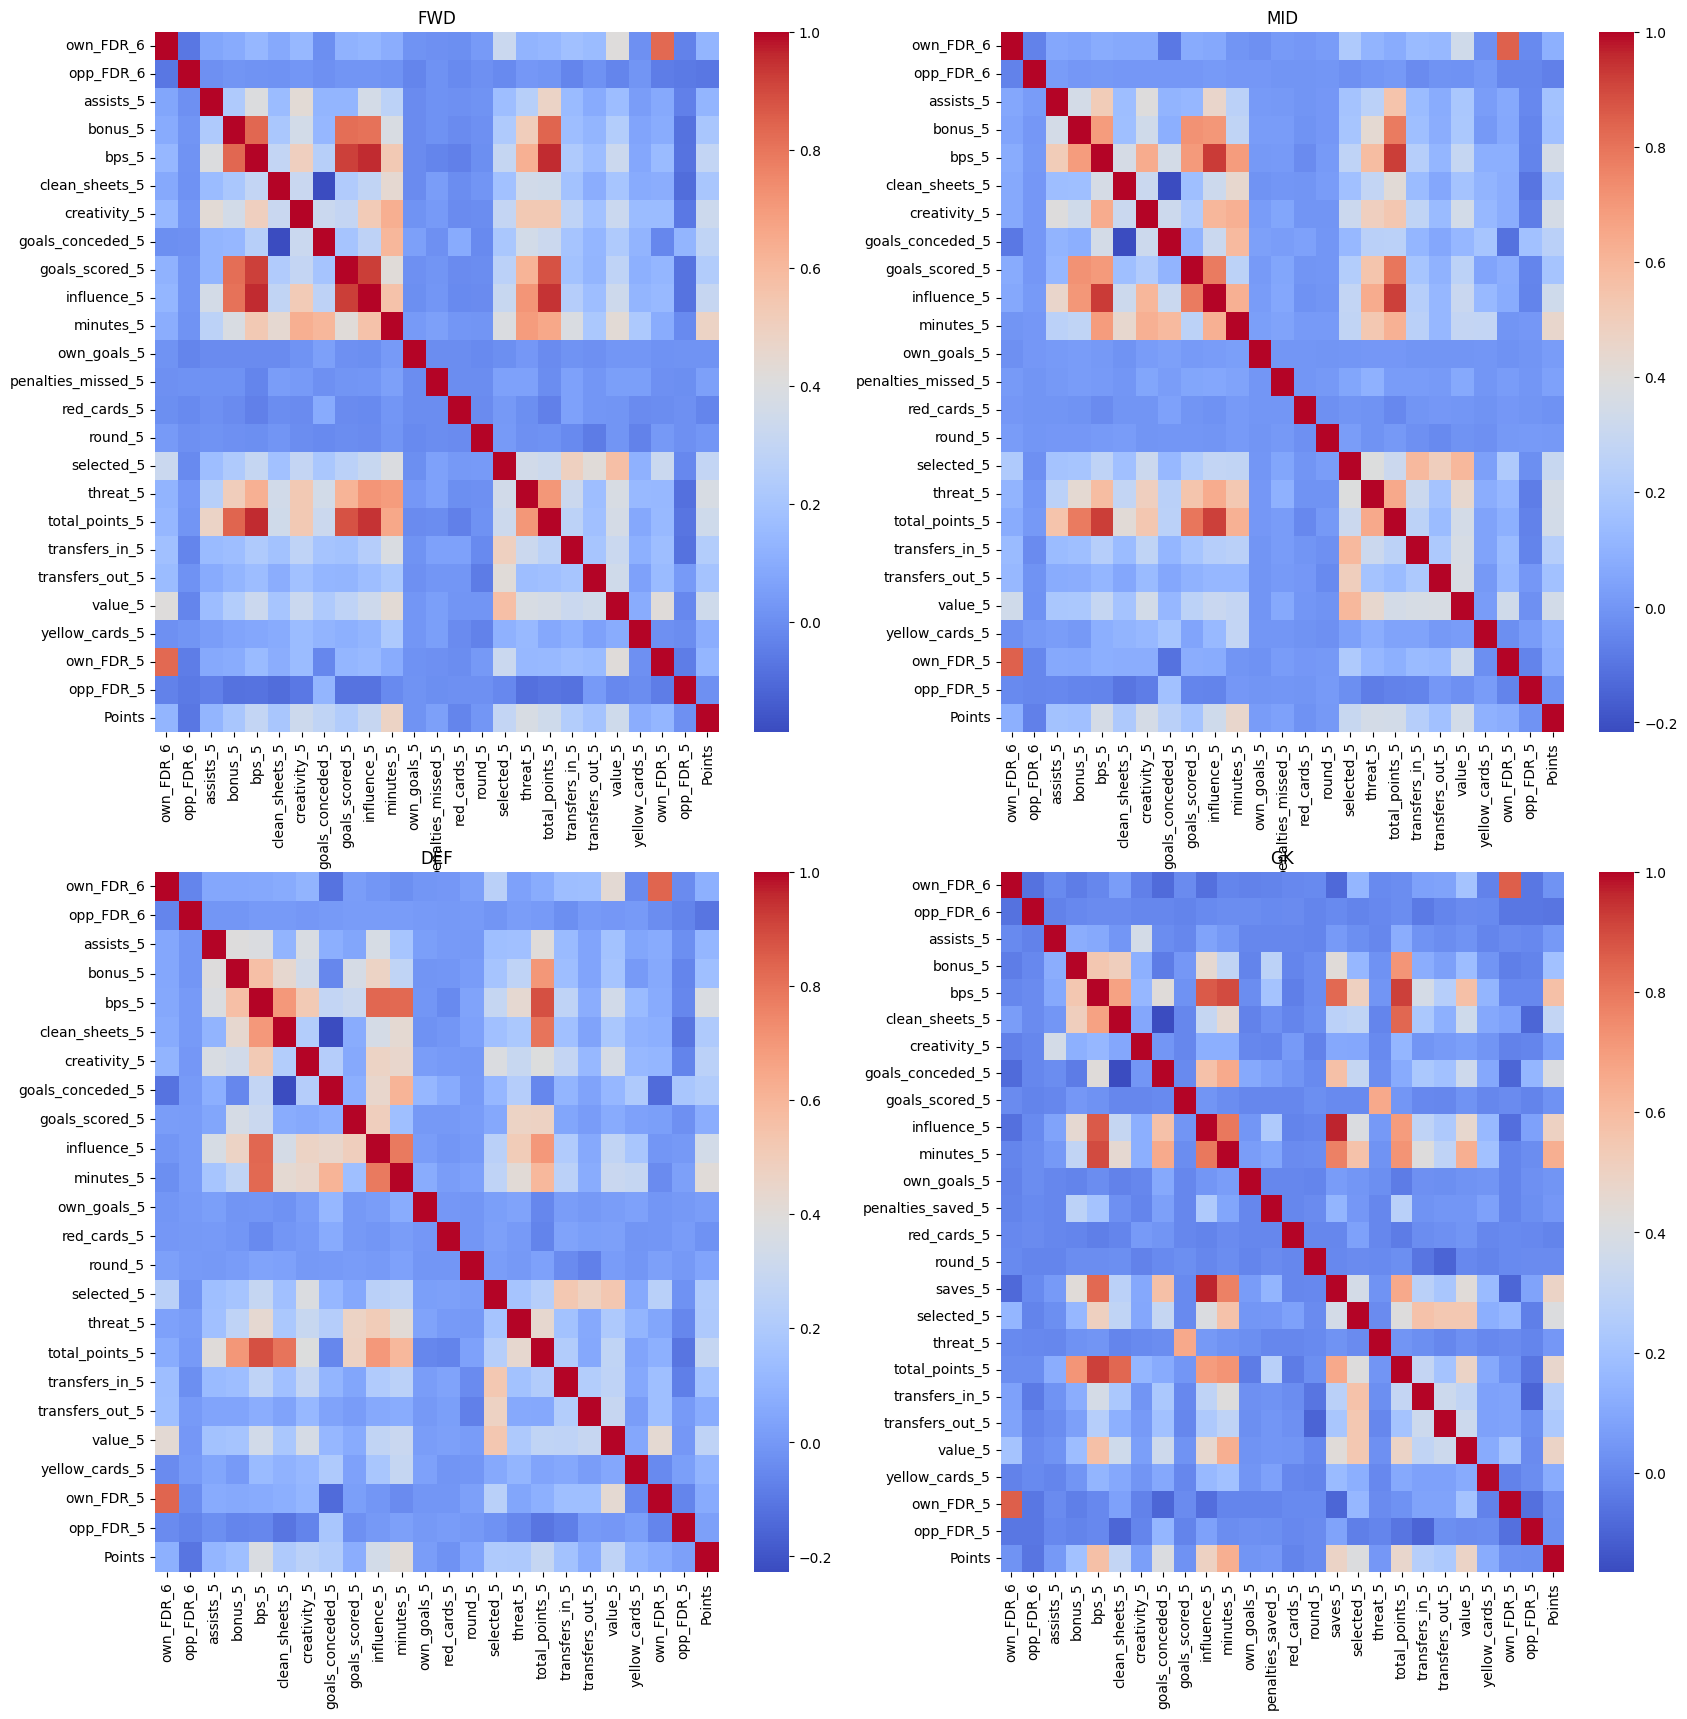

In [56]:
# Get a correlation matrix and view it as a heatmap
def heatmap(data, labels, ax, pos):
    correlation_matrix = pd.concat([data.iloc[:, :2], data.iloc[:, -int(data.shape[1]//5):],
                                    labels], axis =  1).corr()
    sns.heatmap(correlation_matrix, cmap='coolwarm', ax = ax)
    ax.set_title(pos)
    return correlation_matrix

fig, axs = plt.subplots(2, 2, figsize = (20, 20))
for i, pos in enumerate(positions):
    correlation_matrix = heatmap(X_train[pos], y_train[pos], axs[i//2, i%2], pos)

# **Abstract Model Class and Accuracy Measure**

In [57]:
# General model class which we can use for the model factory
class model:

    # Sets the values of the common variables used for each model
    def base_setter(self, name, preprocess, scoring):
        self.preprocess                 = preprocess
        self.scoring                    = scoring
        self.name                       = name
        self.model                      = None
        self.save_path                  = f"drive/MyDrive/Premier_League_Predictor/saved_models/{name}.pkl"

    # Abstract initializer
    def __init__(self, name, preprocess = lambda X : X, scoring = 'neg_mean_squared_error'):
        self.base_setter(name, preprocess, scoring)

    # Training and hyperparameter tuning stays the same across most models
    def train(self, X_train, y_train):
        X_train_pred                    = X_train.copy()
        X_train                         = self.preprocess(X_train)

        # Check if model is already trained
        if os.path.exists(self.save_path):
            self.model                  = joblib.load(self.save_path)

        # Tune hyperparameters
        elif self.scoring:
            grid_search = GridSearchCV(
                             estimator  = self.model,
                             param_grid = self.param_grid,
                             scoring    = self.scoring
                          )
            grid_search.fit(X_train, y_train)
            self.model                  = grid_search.best_estimator_
            joblib.dump(self.model, self.save_path)

        # Fit model
        else:
            self.model.fit(X_train, y_train)
            joblib.dump(self.model, self.save_path)

        return self.predict(X_train_pred)

    # Inference
    def predict(self, X):
        X                               = self.preprocess(X)
        return self.model.predict(X)

    # Naming
    def __repr__(self):
      return self.name

In [58]:
# Run model inference and return PnL on train set, test set
def test_model(model, pos):
    y_train_pred                        = model.predict(X_train[pos])
    y_test_pred                         = model.predict(X_test[pos])

    train_error                         = mean_squared_error(y_train_pred, y_train[pos])
    test_error                          = mean_squared_error(y_test_pred, y_test[pos])

    return train_error, test_error

# **Model Factory**

In [59]:
# Some linear models for the factory

# Ridge regression
class ridge(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = 'neg_mean_squared_error'):
        self.base_setter(name, preprocess, scoring)
        self.model                      = Ridge()
        self.param_grid                 = [{'alpha': [10**n for n in range(-3, 3)]}]

# Lasso regression
class lasso(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = 'neg_mean_squared_error'):
        self.base_setter(name, preprocess, scoring)
        self.model                      = Lasso()
        self.param_grid                 = [{'alpha': [10**n for n in range(-3, 2)]}]

# Combination of ridge and lasso
class elasticnet(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = 'neg_mean_squared_error'):
        self.base_setter(name, preprocess, scoring)
        self.model                      = ElasticNet()
        self.param_grid                 = [{'alpha':    [10**n for n in range(-3, 3)]},
                                           {'l1_ratio': [10**n for n in range(-3, 1)]}]

In [60]:
# Some tree-based models

# XGboost for Regression on PnL
class xgboost(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = 'neg_mean_squared_error', objective = 'reg:squarederror'):
        self.base_setter(name, preprocess, scoring)
        self.model                      = xgb.XGBRegressor(objective = objective)
        self.param_grid                 = { 'max_depth': [3, 4, 5],
                                            'learning_rate': [1e-1, 1e-2, 1e-3],
                                            'n_estimators': [100, 200, 300] }

# CatBoost for Classification of profitable trades
class catboost(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = None):
        self.base_setter(name, preprocess, scoring)
        self.model                      = CatBoostRegressor(verbose = 0)
        self.param_grid                 = { 'iterations': [100, 200, 300],
                                            'learning_rate': [0.01, 0.1, 0.2],
                                            'depth': [4, 6, 8],
                                            'loss_function': ['RMSE'], }

In [61]:
# Now a neural network
class Dense_Neural(model):
    def __init__(self, name, preprocess = lambda X : X.values, scoring = None, n = 67, optimizer = 'Adam',
                 layer_dims = [128, 64, 32, 16], activation = 'relu', dropout = 0.2):
        self.base_setter(name, preprocess, scoring)
        self.save_path                  = f"drive/MyDrive/Premier_League_Predictor/saved_models/{name}.keras"
        self.param_grid                 = None
        self.callbacks                  = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                                             patience=2, min_lr=0.0001)]
        layer_arr                       = []
        for i in layer_dims[:-1]:
          layer_arr                    += [layers.Dense(i, activation=activation), layers.Dropout(dropout)]
        self.model                      = Sequential(layer_arr + [layers.Dense(1, activation = None)])
        self.model.compile(optimizer    = optimizer,
                           loss         = 'mean_squared_error')

    def train(self, X_train, y_train):
        X_train_pred                    = X_train.copy()
        X_train                         = self.preprocess(X_train)
        if os.path.exists(self.save_path):
            self.model                  = keras.models.load_model(self.save_path)
        else:
            x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=True)
            self.model.fit(x_train, y_train,
                           epochs          = 25,
                           validation_data = (x_val, y_val),
                           callbacks       = self.callbacks)
            self.model.save(self.save_path)
    def predict(self, X):
        X                               = self.preprocess(X)
        return self.model.predict(X)

# **Model Losses and Comparison**

In [62]:
trained_models                                = {i:{} for i in positions}
train_error                                   = {i:{} for i in positions}
test_error                                    = {i:{} for i in positions}

In [ ]:
models                                        = {i:{} for i in positions}

for pos in positions:

    # Neural Net
    models[pos][f'{pos}_Dense_Neural_Adam']          = Dense_Neural
    models[pos][f'{pos}_Dense_Neural_RMSprop']       = lambda name : Dense_Neural(name, optimizer = 'RMSprop')
    models[pos][f'{pos}_Dense_Neural_100_50_25_12']  = lambda name : Dense_Neural(name, layer_dims = [100, 50, 25, 12])
    models[pos][f'{pos}_Dense_Neural_0.35']          = lambda name : Dense_Neural(name, dropout = 0.35)
    models[pos][f'{pos}_Dense_Neural_sigmoid']       = lambda name : Dense_Neural(name, activation = 'sigmoid')

    # What if expected points is literally just E[points] given past 5 game points with uniform prob?
    models[pos][f'{pos}_use_means']                  = None
    trained_models[pos][f'{pos}_use_means']          = None
    y_train_pred                                     = pd.concat([X_train[pos][f"total_points_{i}"] for i in range(1, 6)], axis=1).sum(axis=1)/5
    y_test_pred                                      = pd.concat([X_test[pos][f"total_points_{i}"] for i in range(1, 6)], axis=1).sum(axis=1)/5
    train_error[pos][f'{pos}_use_means']             = mean_squared_error(y_train_pred, y_train[pos])
    test_error[pos][f'{pos}_use_means']              = mean_squared_error(y_test_pred, y_test[pos])

    # Linear Models
    models[pos][f'{pos}_elasticnet_no_preprocess']   = elasticnet
    models[pos][f'{pos}_ridge_no_preprocess']        = ridge
    models[pos][f'{pos}_lasso_no_preprocess']        = lasso

    # Tree-based Models
    models[pos][f'{pos}_xgboost_no_tuning']          = xgboost
    models[pos][f'{pos}_catoost_no_tuning']          = catboost
    models[pos][f'{pos}_catboost_27_tuned']          = lambda name : catboost(name, scoring = 'neg_mean_squared_error')
    models[pos][f'{pos}_xgboost_27_tuned']           = lambda name : xgboost(name, scoring = 'neg_mean_squared_error')

    # Train-test loop for model factory
    for i, name in enumerate(models[pos].keys()):
        if not name in trained_models[pos]:
            temp                                     = models[pos][name](name)
            temp.train(X_train[pos], y_train[pos])
            trained_models[pos][name]                = temp
        if not name in train_error[pos]:
            train_error[pos][name], test_error[pos][name] = test_model(trained_models[pos][name], pos)
        print(f'Model: {name}; Train Error: {train_error[pos][name]}; Test Error: {test_error[pos][name]}')

Epoch 1/25
148/148 [==============================] - 4s 10ms/step - loss: 24.3072 - val_loss: 9.3294 - lr: 0.0010
Epoch 2/25
148/148 [==============================] - 1s 5ms/step - loss: 9.3363 - val_loss: 8.4582 - lr: 0.0010
Epoch 3/25
148/148 [==============================] - 1s 7ms/step - loss: 8.8853 - val_loss: 7.7288 - lr: 0.0010
Epoch 4/25
148/148 [==============================] - 2s 10ms/step - loss: 8.0997 - val_loss: 7.7612 - lr: 0.0010
Epoch 5/25
148/148 [==============================] - 2s 11ms/step - loss: 7.8938 - val_loss: 7.6191 - lr: 0.0010
Epoch 6/25
148/148 [==============================] - 2s 10ms/step - loss: 7.6190 - val_loss: 7.2413 - lr: 0.0010
Epoch 7/25
148/148 [==============================] - 1s 8ms/step - loss: 7.4938 - val_loss: 7.5258 - lr: 0.0010
Epoch 8/25
148/148 [==============================] - 1s 7ms/step - loss: 7.6551 - val_loss: 7.3550 - lr: 0.0010
Epoch 9/25
148/148 [==============================] - 1s 8ms/step - loss: 7.4453 - val_loss

# **Results Visualization**

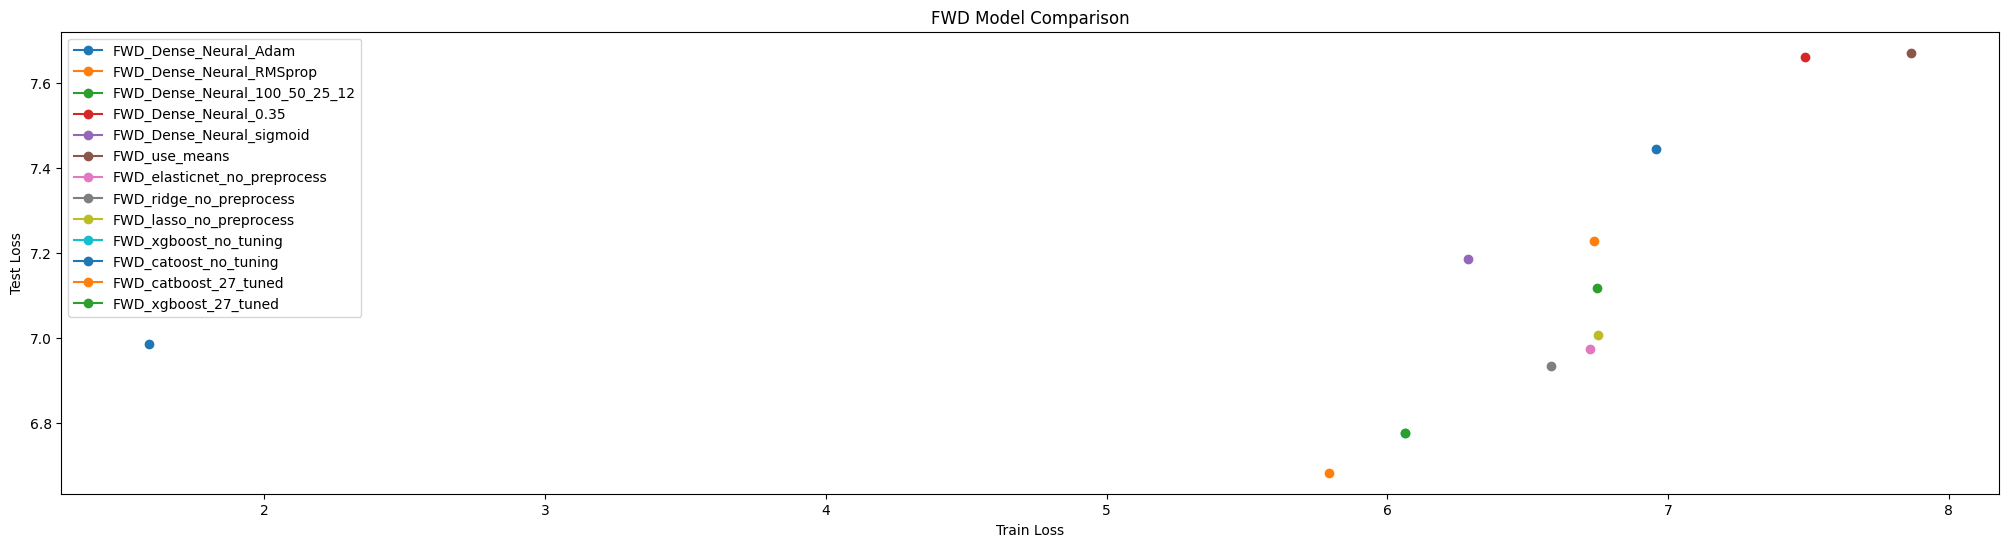

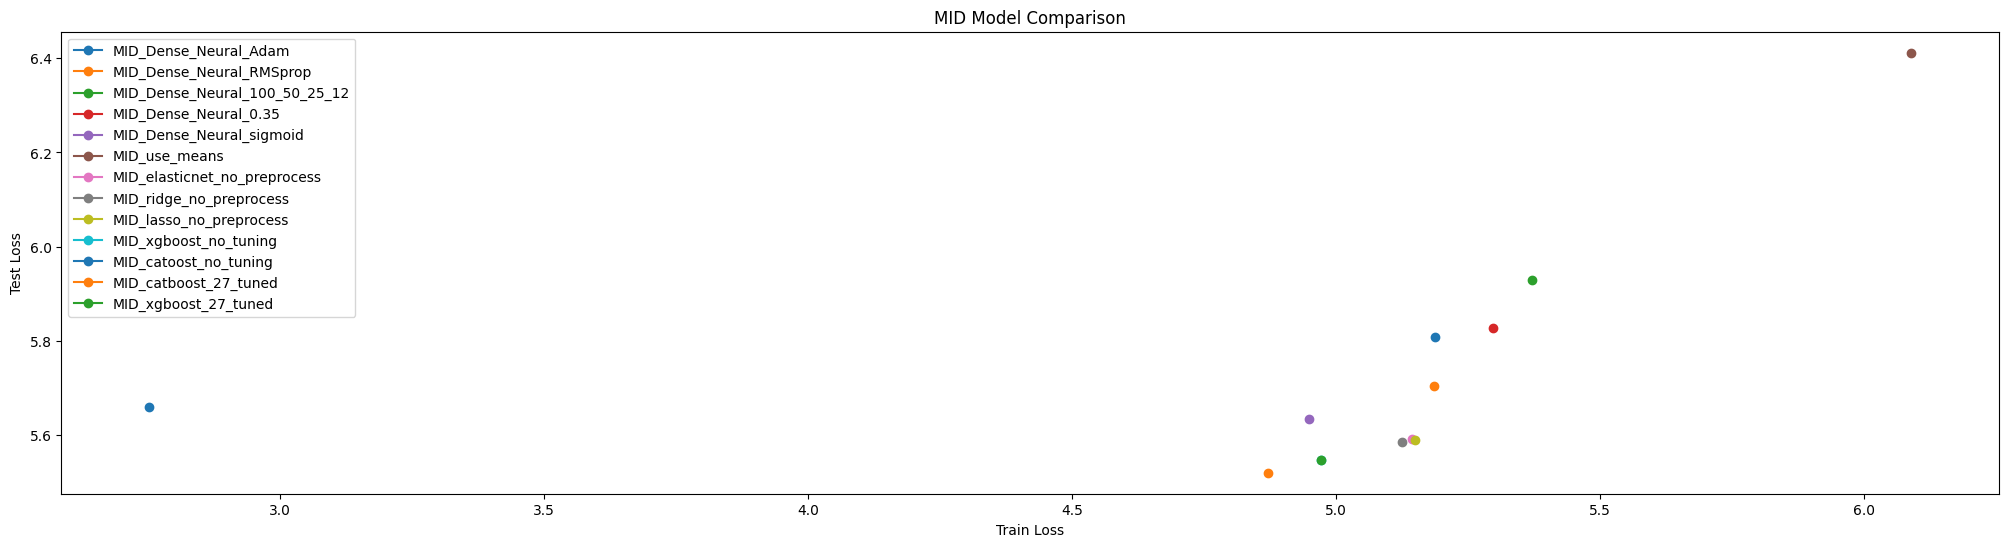

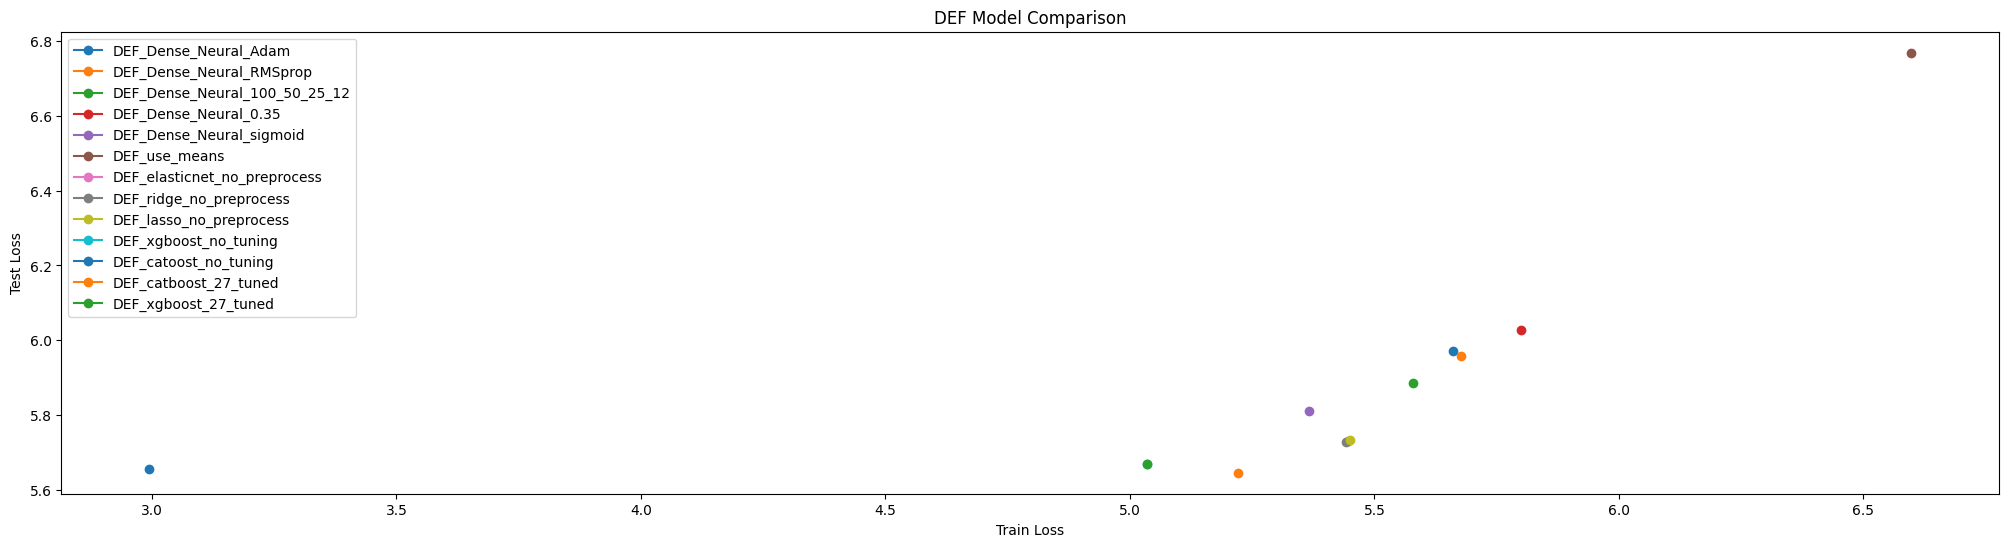

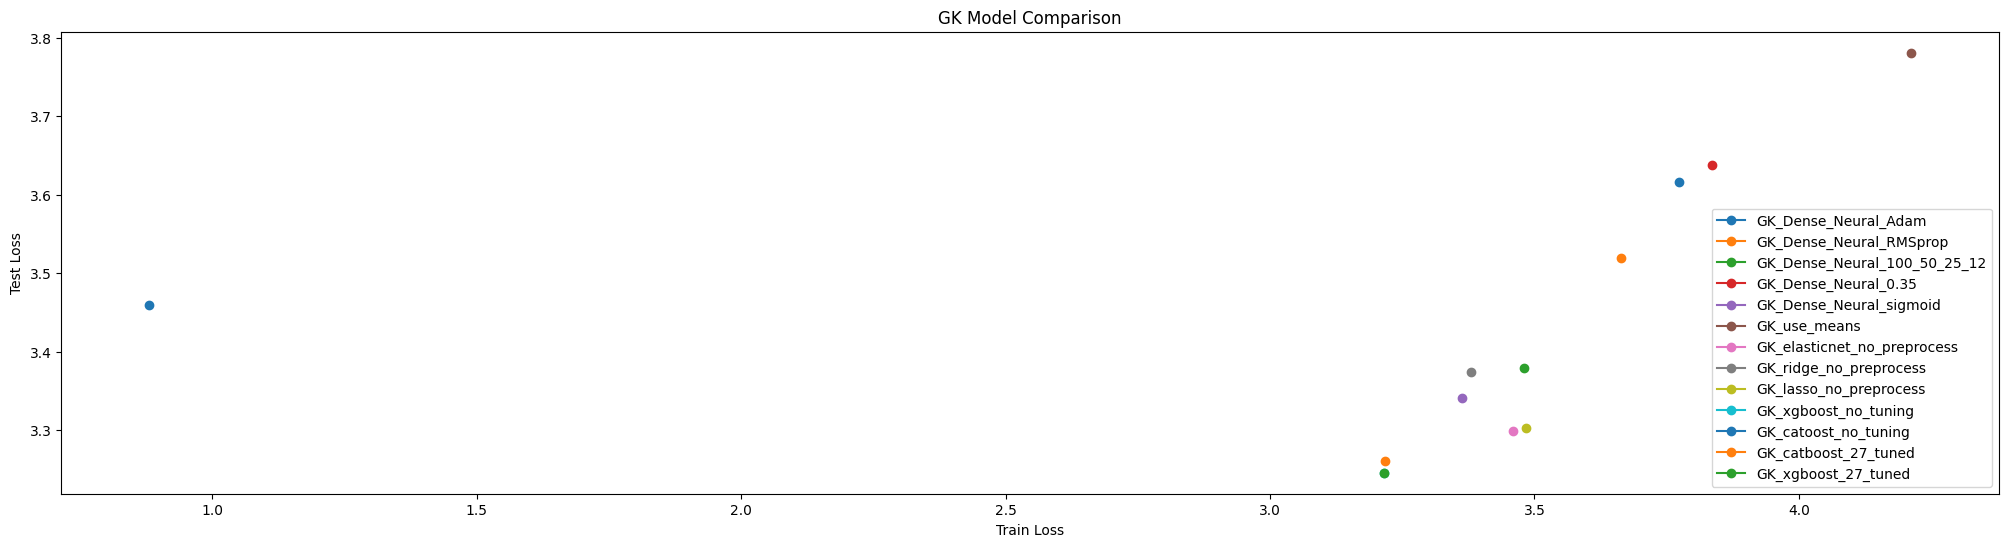

In [ ]:
for pos in positions:
  plt.figure(figsize = (25,6))
  for i in models[pos].keys():
    plt.plot(train_error[pos][i], test_error[pos][i], marker = 'o', label = i)
  plt.xlabel('Train Loss')
  plt.ylabel('Test Loss')
  plt.title(f'{pos} Model Comparison')
  plt.legend()
  plt.ylim()